In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import fastsparsegams
import time
import pandas as pd

### Define DGP

#### Define DGP functions

In [3]:
class DGP: 
    #Returns X_aug, X_indicator, y
    #no intercept augmentation of dataset because the model has an automatic intercept. 
    def data_gen(self, **kwargs):
        return "Not Yet Implemented - We expect children to implement a data generation process."
    
    #give P(Y=1) for each observation (row) in X
    def estimate_true_probs(self, X, n = 1000, verbose=True, **kwargs): 
        #default behaviour: estimate empirically from DGP
        X_interaction, X_indicator, y = self.data_gen(n=n)
        
        sample_X = X_interaction
        if X_interaction.shape[1] != X.shape[1]: 
            if X_indicator.shape[1] != X.shape[1]: 
                print("ERROR! not the right shape")
            else: 
                sample_X = X_indicator
        
        true_probs = np.ones(X.shape[0])
        for i, row in enumerate(X): 
            #if the observation was seen at least once in the sample, 
            # use the empirical distribution to estimate the true probability
            if (row == sample_X).all(axis=1).any(): 
                true_probs[i] = y[(row == sample_X).all(axis=1)].mean()
            else: 
                #otherwise print an error and use a less precise estimate: 
                true_probs[i] = y.mean()
                if verbose: 
                    print("Observation ", row, "was not found in the generated sample,", 
                          "so probability was estimated based on all points.",
                          "Possible solutions might be: increasing the number of samples,", 
                          "using a closed form for this case instead of an empirical estimate,",
                         "modifying this (inherited) function to encode some independence assumptions",
                          "(like encoding the independence between y and a variable that is just noise),",
                         "or reducing the number of variables in the DGP so that exact matches are more likely.")
        return true_probs
    
    def true_probs(self, X, verbose=True, **kwargs): 
        if verbose: 
            print('Closed form not encoded; approximating with empirical estimate')
        return self.estimate_true_probs(X, verbose=verbose) #may want to pass along kwargs as well
        

In [4]:
class MCAR_noisy_recovery(DGP): 
    def __init__(self, n_vars=3, y_noise = 0, x_noise = 0): 
        self.n_vars = n_vars
        self.y_noise = y_noise
        if y_noise > 1 or y_noise < 0: 
            print("Error! Noise must be between 0 and 1, inclusive.")
        if np.shape(x_noise) == (): 
            x_noise = np.ones(n_vars) * x_noise #todo: make missingness noise a separate argument? 
        elif np.shape(x_noise) != (n_vars,): 
            print("Error! x_noise must be a scalar or an array of length n_vars+1 (last entry is noise for missingness).")
        self.x_noise = x_noise
        
    def data_gen(self, n=10000, correlation_prop = 0.85, missingness_prop = 0.4, seed = None): 
        if self.n_vars < 2: 
            print('not enough variables!')
            return -1, -1, -1, -1

        if seed is not None: 
            np.random.seed(seed)

        X = np.random.choice([True, False], (n,self.n_vars+1))

        #with rate correlation_prop, X_:0 is equal to X_:1
        correlation_indices = np.random.permutation(n)[:int(correlation_prop*n)]
        X[correlation_indices, 0] = X[correlation_indices, 1]

        #Y is always X_:0
        y = np.copy(X[:, 0])

        #X_:0 is sometimes missing
        missing_indices = np.random.permutation(n)[:int(missingness_prop*n)]
        X[missing_indices, 0] = False
        #last column X_:-1 is missingness indicator for X_:0
        X[:, -1] = False
        X[missing_indices, -1] = True

        #noising: swap some 0 and 1 values in x and y: 
        y_noise_indices = np.random.permutation(n)[:int(self.y_noise*n)]
        y[y_noise_indices] = np.logical_not(y[y_noise_indices])

        for i in range(len(self.x_noise)): 
            x_noise_indices = np.random.permutation(n)[:int(self.x_noise[i]*n)]
            X[x_noise_indices, i] = np.logical_not(X[x_noise_indices, i])

        #create augmented matrix (add interaction terms): 
        X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)

        return X_aug, X, y
    
    def true_probs(self, X): 
        true_probs = np.zeros(X.shape[0])
        
        # if X_.0 is true, then y is 100% true
        true_probs[X[:, 0]] = 1
        
        # if X_.0 is missing (indicator is X_.[nvars]), then we base probabilities off of X_.1
        true_probs[X[:, self.n_vars]] = X[:, 1][X[:, self.n_vars]].astype(float) * 0.85 + 0.075
        
        #else y is 0% true (as covered by initialization with np.zeros)
        
        return true_probs

In [5]:
class MNAR_arbitrary_op(DGP): #run any operation on X_:0's missingness indicator and X_:1, adding optional noise
    def __init__(self, n_vars=3, y_noise = 0, x_noise = 0, operation = lambda mi, x1: np.logical_or(mi, x1)): 
        self.n_vars = n_vars
        self.operation = operation
        self.y_noise = y_noise
        if y_noise > 1 or y_noise < 0: 
            print("Error! Noise must be between 0 and 1, inclusive.")
        if np.shape(x_noise) == (): 
            x_noise = np.ones(n_vars+1) * x_noise #todo: make missingness noise a separate argument? 
        elif np.shape(x_noise) != (n_vars+1,): 
            print("Error! x_noise must be a scalar or an array of length n_vars+1 (last entry is noise for missingness).")
        self.x_noise = x_noise
        
    def data_gen(self, n=10000, missingness_prop = 0.4, seed = None): 
        if self.n_vars < 2: 
            print('not enough variables!')
            return -1, -1, -1, -1

        if seed is not None: 
            np.random.seed(seed)

        X = np.random.choice([True, False], (n,self.n_vars+1))

        #X_:0 is sometimes missing
        missing_indices = np.random.permutation(n)[:int(missingness_prop*n)]
        X[missing_indices, 0] = False
        #last column X_:-1 is missingness indicator for X_:0
        X[:, -1] = False
        X[missing_indices, -1] = True

        #Y is always X_.1 [logical operator] indicator X_.0 is missing
        y = self.operation(X[:, -1], X[:, 1])

        #noising: swap some 0 and 1 values in y: 
        y_noise_indices = np.random.permutation(n)[:int(self.y_noise*n)]
        y[y_noise_indices] = np.logical_not(y[y_noise_indices])

        for i in range(len(self.x_noise)): 
            x_noise_indices = np.random.permutation(n)[:int(self.x_noise[i]*n)]
            X[x_noise_indices, i] = np.logical_not(X[x_noise_indices, i])

        #create augmented matrix (add interaction terms): 
        X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)

        return X_aug, X, y
    
    def true_probs(self, X):

        true_probs = np.zeros(X.shape[0])
        #Y is always X_.1 [logical operator] indicator X_.0 is missing

        #Split into cases, with corresponding probabilities: 
        # Case 1: neither feature is flipped: 
        true_probs += self.operation(X[:, self.n_vars], X[:, 1]) * (1 - self.x_noise[1]) * (1 - self.x_noise[self.n_vars])
        # only X_:1 is flipped:
        true_probs += self.operation(X[:, self.n_vars], np.logical_not(X[:, 1])) * (self.x_noise[1]) * (1 - self.x_noise[self.n_vars])
        # only missingness indicator is flipped:
        true_probs += self.operation(np.logical_not(X[:, self.n_vars]), (X[:, 1])) * (1 - self.x_noise[1]) * (self.x_noise[self.n_vars])
        # both are flipped:
        true_probs += self.operation(np.logical_not(X[:, self.n_vars]), np.logical_not(X[:, 1])) * (self.x_noise[1]) * (self.x_noise[self.n_vars])

        # account for the noising of the label: 
        true_probs = (1 - self.y_noise) * true_probs + self.y_noise * (1 - true_probs)
        
        return true_probs

In [7]:
# class where missingness for x1 can be a function of y, x1's true value, and a covariate x2
# y can be modeled as a function of the covariates x1, x2, and x3
# we could alternatively model y as a function of the indicator, or remain with the indicator being a function of y
# perhaps it is easiest just to specify a joint model over y and missingness?
# This class currently does not have the true probabilities implemented, but they can be approximated with the default implementation from the parent class
# currently fixed at exactly 4 features, but this is easy to change
class functional_dgp(DGP):
    def __init__(self, prob_y_true = lambda x1, x2, x3: 0.25 + 0.2*x1 + 0.2*x2 + 0.2*x3, miss_prob = lambda y, x1, x2: 0.4): 
        self.miss_prob = miss_prob
        self.prob_y_true = prob_y_true

    
    def data_gen(self, n=10000, seed = None):
        if seed is not None: 
            np.random.seed(seed)

        X = np.random.choice([True, False], (n,4)) #x1, x2, x3 and missingness indicator

        #Y follows a function of X_:0, X_:1, and X_:2
        y = np.random.binomial(1, self.prob_y_true(X[:, 0], X[:, 1], X[:, 2]))

        #X_:0 is sometimes missing
        missing = np.random.binomial(1, self.miss_prob(y, X[:, 0], X[:, 1])).astype(bool)
        X[missing, 0] = False
        #last column X_:-1 is missingness indicator for X_:0
        X[:, -1] = False
        X[missing, -1] = True

        #create augmented matrix (add interaction terms): 
        X_aug = np.concatenate([X, np.logical_and(X[:, -1].reshape(-1, 1), X[:, 1:-1])], axis=1)

        return X_aug, X, y

    #Uses last column of X as missingness indicator for first column, 
    # fills in the missing values with specified imputation strategy, 
    # and removes the last column
    def impute(self, X, y, strategy='MVI'):
        imputed_X = np.copy(X[:, :-1])
        missing = X[:, -1].astype(bool)
        if strategy == 'MVI': 
            imputed_X[missing, 0] = X[np.logical_not(missing), 0].mean() > 0.5
            return imputed_X
        elif strategy == 'best': #TODO: verify method for doing this on test vs train, if function depends on y
            #maximize likelihood (we'll use false if true and false are equally likely)
            #TODO: complete this approach. Will need to consider the full joint distribution, and maximize it, 
            # but it is unclear how to do incorporate y. The below code would work if 
            # y was independent of X_:0 but we still know y for the dependence on the missingness of X_:0, 
            # which is unrealistic for many reasons
            probs_true = self.miss_prob(y[missing], np.ones(missing.sum()), X[missing, 1])
            probs_false = self.miss_prob(y[missing], np.zeros(missing.sum()), X[missing, 1])
            imputed_X[missing, 0] = probs_true > probs_false
            return imputed_X
        else: 
            return "stub; Not supported"

#### Select DGP

In [8]:
# dgp = MCAR_noisy_recovery(n_vars=3)#MNAR_arbitrary_op(n_vars=3, y_noise = 0, x_noise = 0, operation = lambda mi, x1: np.logical_or(mi, x1))

# dgp = MCAR_noisy_recovery(n_vars=3, y_noise = 0.04, x_noise=0.04)

dgp = functional_dgp(miss_prob = lambda y, x1, x2: 0.1 * np.logical_not(np.logical_xor(y, x2)))

### Generate train/test data

In [9]:
X_aug_train, X_indicator_train, y_train = dgp.data_gen(n=100000, seed=2)#1000)
X_aug_test, X_indicator_test, y_test = dgp.data_gen(n=100000, seed=1)#1001)

### Fit models

#### Fit on data with interactions (augmented data)

In [10]:
model_aug = fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)

#### Fit on indicator-only data

In [11]:
model_indicator = fastsparsegams.fit(
    X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
)

#### Fit with Mean Value Imputation

In [12]:
X_mvi_train = dgp.impute(X_indicator_train, y_train)
X_mvi_test = dgp.impute(X_indicator_test, y_test)

In [13]:
model_mvi = fastsparsegams.fit(
    X_mvi_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", algorithm="CDPSI"
)

In [17]:
# X_impute_train = dgp.impute(X_indicator_train, y_train, strategy='best')
# X_impute_test = dgp.impute(X_indicator_test, y_test, strategy='best')

In [18]:
# model_impute = fastsparsegams.fit(
#     X_impute_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", algorithm="CDPSI"
# )

In [19]:
(X_mvi_train == X_indicator_train[:, :-1]).all(axis=1).sum()

93979

In [20]:
missing = X_indicator_train[:, -1]
X_indicator_train[np.logical_not(missing), 0].mean()

0.5021653773715404

#### Define model evaluation helper

In [21]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs

### Eval models

In [22]:
train_probs_aug, test_probs_aug, coeff_aug = eval_model(model_aug, X_aug_train, X_aug_test)

In [23]:
trainacc_aug = ((train_probs_aug > 0.5) == y_train).mean(axis = 1)
testacc_aug = ((test_probs_aug > 0.5) == y_test).mean(axis = 1)
num_terms_aug = (coeff_aug != 0).sum(axis=1)

In [24]:
train_probs_indicator, test_probs_indicator, coeff_indicator = eval_model(model_indicator, X_indicator_train, X_indicator_test)

In [25]:
trainacc_indicator = ((train_probs_indicator > 0.5) == y_train).mean(axis=1)

In [26]:
testacc_indicator = ((test_probs_indicator > 0.5) == y_test).mean(axis=1)

In [27]:
num_terms_indicator = (coeff_indicator != 0).sum(axis=1)

In [28]:
train_probs_mvi, test_probs_mvi, coeff_mvi = eval_model(model_mvi, X_mvi_train, X_mvi_test)
trainacc_mvi = ((train_probs_mvi > 0.5) == y_train).mean(axis=1)
testacc_mvi = ((test_probs_mvi > 0.5) == y_test).mean(axis=1)
num_terms_mvi = ((coeff_mvi != 0).sum(axis=1))

In [29]:
# train_probs_impute, test_probs_impute, coeff_impute = eval_model(model_impute, X_impute_train, X_impute_test)
# trainacc_impute = ((train_probs_impute > 0.5) == y_train).mean(axis=1)
# testacc_impute = ((test_probs_impute > 0.5) == y_test).mean(axis=1)
# num_terms_impute = ((coeff_impute != 0).sum(axis=1))

### Plot of basic accuracy/sparsity results

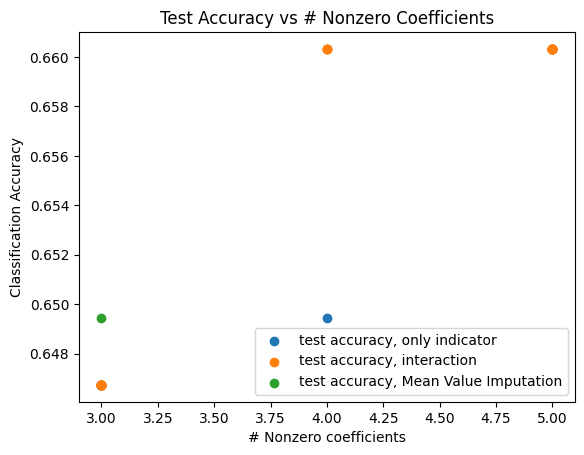

In [30]:
plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.scatter(num_terms_indicator[num_terms_indicator > 0], testacc_indicator[num_terms_indicator > 0], label='test accuracy, only indicator')
plt.scatter(num_terms_aug[num_terms_aug > 0], testacc_aug[num_terms_aug > 0], label='test accuracy, interaction')
plt.scatter(num_terms_mvi[num_terms_mvi > 0], testacc_mvi[num_terms_mvi > 0], label='test accuracy, Mean Value Imputation')
# plt.scatter(num_terms_impute[num_terms_impute > 0], testacc_impute[num_terms_impute > 0], label='test accuracy, Best Imputation (w/ access to labels...)')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

# Calibration, Objective, etc

In [31]:
true = dgp.true_probs(X_aug_train)
true_test = dgp.true_probs(X_aug_test)

Closed form not encoded; approximating with empirical estimate
Closed form not encoded; approximating with empirical estimate


In [32]:
calibration_no_interaction = np.linalg.norm(train_probs_indicator - true, axis=1)
calibration_interaction = np.linalg.norm(train_probs_aug - true, axis=1)
calibration_mvi = np.linalg.norm(train_probs_mvi - true, axis=1)
# calibration_impute = np.linalg.norm(train_probs_impute - true, axis=1)

calibration_no_interaction_test = np.linalg.norm(test_probs_indicator - true_test, axis=1)
calibration_interaction_test = np.linalg.norm(test_probs_aug - true_test, axis=1)

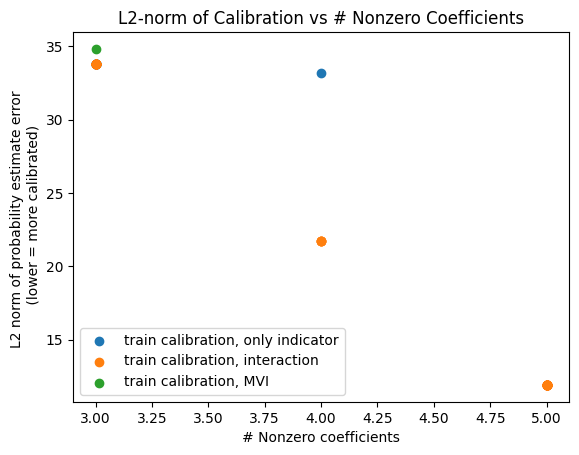

In [33]:
plt.title('L2-norm of Calibration vs # Nonzero Coefficients')#\n (Other than intercept)
plt.scatter(num_terms_indicator[num_terms_indicator > 0], calibration_no_interaction[num_terms_indicator > 0], label='train calibration, only indicator')
plt.scatter(num_terms_aug[num_terms_aug > 0], calibration_interaction[num_terms_aug > 0], label='train calibration, interaction')
plt.scatter(num_terms_mvi[num_terms_mvi > 0], calibration_mvi[num_terms_mvi > 0], label='train calibration, MVI')
# plt.scatter(num_terms_impute[num_terms_impute > 0], calibration_impute[num_terms_impute > 0], label='train calibration, Imputation')
# plt.plot(num_terms_aug[num_terms_aug > 0], calibration_interaction_test[num_terms_aug > 0], label='test calibration, interaction')
# plt.plot(num_terms_indicator[num_terms_indicator > 0], calibration_no_interaction_test[num_terms_indicator > 0], label='test calibration, only indicator')
plt.ylabel('L2 norm of probability estimate error \n (lower = more calibrated)')
plt.xlabel('# Nonzero coefficients')

plt.legend()

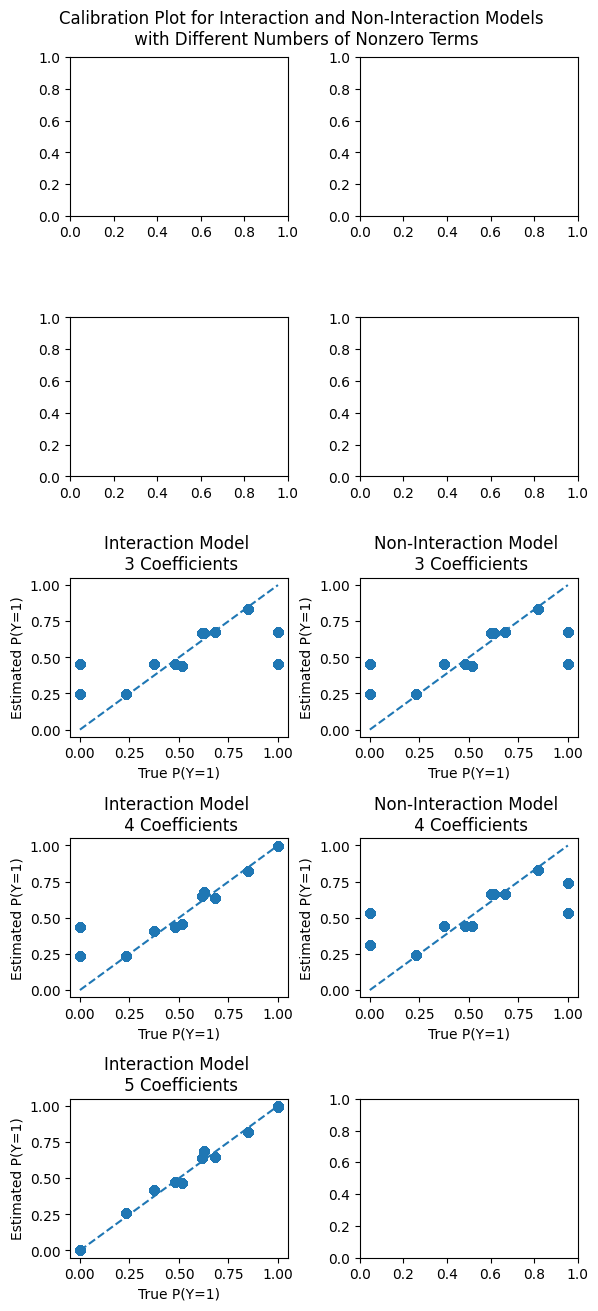

In [34]:
fig, axs = plt.subplots(num_terms_aug[-1], 2, figsize=(6,8/3*num_terms_aug[-1]))

plt.suptitle("Calibration Plot for Interaction and Non-Interaction Models \n with Different Numbers of Nonzero Terms")

for num_coef in range(1, num_terms_aug[-1]+1): 
    if num_coef in num_terms_aug: 
        axs[num_coef-1, 0].scatter(true, train_probs_aug[num_terms_aug == num_coef, :][0])
        axs[num_coef-1, 0].plot([0, 1], [0, 1], linestyle='dashed', label='line of perfect calibration')
        axs[num_coef-1, 0].set_title('Interaction Model \n %d Coefficient'%num_coef + 
                                 ('s' if num_coef != 1 else ''))
        axs[num_coef-1, 0].set_xlabel('True P(Y=1)')
        axs[num_coef-1, 0].set_ylabel('Estimated P(Y=1)')
    
    if num_coef in num_terms_indicator:
        axs[num_coef-1, 1].scatter(true, train_probs_indicator[num_terms_indicator == num_coef, :][0])
        axs[num_coef-1, 1].plot([0, 1], [0, 1], linestyle='dashed', label='line of perfect calibration')
        axs[num_coef-1, 1].set_title('Non-Interaction Model \n %d Coefficient'%num_coef + 
                                 ('s' if num_coef != 1 else ''))
        axs[num_coef-1, 1].set_xlabel('True P(Y=1)')
        axs[num_coef-1, 1].set_ylabel('Estimated P(Y=1)')

fig.tight_layout()

#todo - get label of dashed calibration line to show up (once and only once) in a common legend

### Recover objective from prediction probability

In [40]:
def objective(probs, y): 
    return np.exp(np.log(probs/(1 - probs))*-1/2*(2*y - 1)).sum(axis=1)

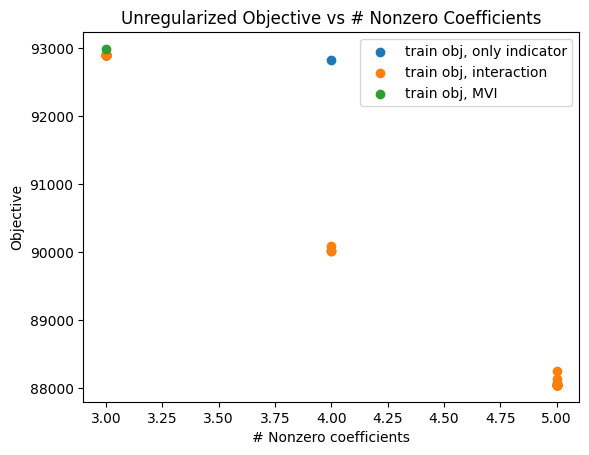

In [41]:
plt.title('Unregularized Objective vs # Nonzero Coefficients')#\n (Other than intercept)
plt.scatter(num_terms_indicator[num_terms_indicator > 0], objective(train_probs_indicator, y_train)[num_terms_indicator > 0], label='train obj, only indicator')
plt.scatter(num_terms_aug[num_terms_aug > 0], objective(train_probs_aug, y_train)[num_terms_aug > 0], label='train obj, interaction')
plt.scatter(num_terms_mvi[num_terms_mvi > 0], objective(train_probs_mvi, y_train)[num_terms_mvi > 0], label='train obj, MVI')
# plt.scatter(num_terms_impute[num_terms_impute > 0], objective(train_probs_impute, y_train)[num_terms_impute > 0], label='train obj, Best imputation')
# plt.plot(num_terms_aug[num_terms_aug > 0], objective(test_probs_aug, y_train)[num_terms_aug > 0], label='test objective, interaction')
# plt.plot(num_terms_indicator[num_terms_indicator > 0], objective(test_probs_indicator, y_train)[num_terms_indicator > 0], label='test objective, only indicator')
plt.ylabel('Objective')
plt.xlabel('# Nonzero coefficients')

plt.legend()

In [42]:
coeff_aug[90]

array([ 0.45423805,  0.35037109,  0.46528117, -4.40548199,  8.50340027,
        0.        ])

#### Runtime tests

In [43]:
# computes average training time of fastsparsegams on a given dataset, as well as 5th and 95th percentiles
# assumes X, y come in the same format as provided by the dgp (so includes processing to make the matrices the right type)
def estimate_runtime(X, y, num_trials=100): 

    times = []
    start = time.time()

    for i in range(num_trials): 
        model = fastsparsegams.fit(
            X.astype(float), y.astype(int)*2 - 1, loss="Exponential", max_support_size=20, algorithm="CDPSI"
        )
        times.append(time.time())
    
    times = [cur - prev for cur, prev in zip(times, [start] + times[:-1])] #compute elapsed time for each trial

    return (np.mean(times), np.quantile(times, 0.05), np.quantile(times, 0.95))

    


In [44]:
# models_to_test = [MCAR_noisy_recovery(n_vars=3), MCAR_noisy_recovery(n_vars=30)]
# model_labels = ['MCAR_noisy_recovery_3vars', 'MCAR_noisy_recovery_30vars']
# bins = np.arange(len(model_labels))

In [45]:
# aug_times = np.zeros((3, len(models_to_test)))
# indicator_times = np.zeros((3, len(models_to_test)))
# for i, dgp in enumerate(models_to_test):
#     X_aug_train, X_indicator_train, y_train = dgp.data_gen(seed=100) #note: may need to vary seed
    
#     aug_times[:, i] = estimate_runtime(X_aug_train, y_train, num_trials=10)
#     indicator_times[:, i] = estimate_runtime(X_indicator_train, y_train, num_trials=10)

In [46]:
# plt.bar(bins, aug_times[0, :], 0.35, label='interaction', yerr=np.abs(aug_times[0, :] - aug_times[1:, :]))
# plt.bar(bins+0.35, indicator_times[0, :], 0.35, label='only indicator', yerr=np.abs(indicator_times[0, :] - indicator_times[1:, :]))
# plt.xticks(bins+0.175, model_labels)
# plt.ylabel('Average Training Time (seconds)')
# plt.legend()
# plt.title('Average Training Time for Interaction and Non-Interaction Models')